In [4]:
# !pip install category_encoders==2.*
# !pip install pandas_profiling==2.*

In [5]:
import sys
# !{sys.executable} -m pip install pandas-profiling

In [6]:
from pandas_profiling import ProfileReport

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 100

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

# I. Wrangle Data

### Import data



In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split 

In [9]:
df = pd.merge(pd.read_csv(r'waterpumps/train_features.csv', na_values = [0]),
     pd.read_csv(r'waterpumps/train_labels.csv', na_values = [0]))

In [10]:
def wrangle(temp_df):

  #set row index to 'id column
  temp_df.set_index('id', inplace = True)

  #Drop the constant column 'recorded by' and the duplicate column 'quantity group'
  df.drop(columns=['recorded_by', 'quantity_group'], inplace = True, errors='ignore')

  # Drop High-Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
  
  # Drop columns with a high proportion of null values
  df.drop(columns='num_private', inplace=True, errors='ignore')
  
  return temp_df


In [11]:
train = wrangle(df)

In [12]:
train.shape

(59400, 29)

### EDA

In [13]:
train.shape
train.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,Lake Nyasa,Iringa,11,5.0,109.0,True,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776.0,NaN,1399.0,34.698766,-2.147466,Lake Victoria,Mara,20,2.0,280.0,NaN,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310.0,25.0,686.0,37.460664,-3.821329,Pangani,Manyara,21,4.0,250.0,True,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743.0,NaN,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728.0,NaN,NaN,31.130847,-1.825359,Lake Victoria,Kagera,18,1.0,NaN,True,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [14]:
train.isnull().sum()

amount_tsh               41639
gps_height               20438
longitude                 1812
latitude                     0
basin                        0
region                       0
region_code                  0
district_code               23
population               21381
public_meeting            3334
scheme_management         3877
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
status_group                 0
dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

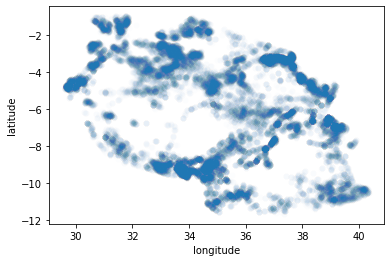

In [15]:
import seaborn as sns

sns.scatterplot(x = 'longitude', y = 'latitude', data = train, alpha = .01)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

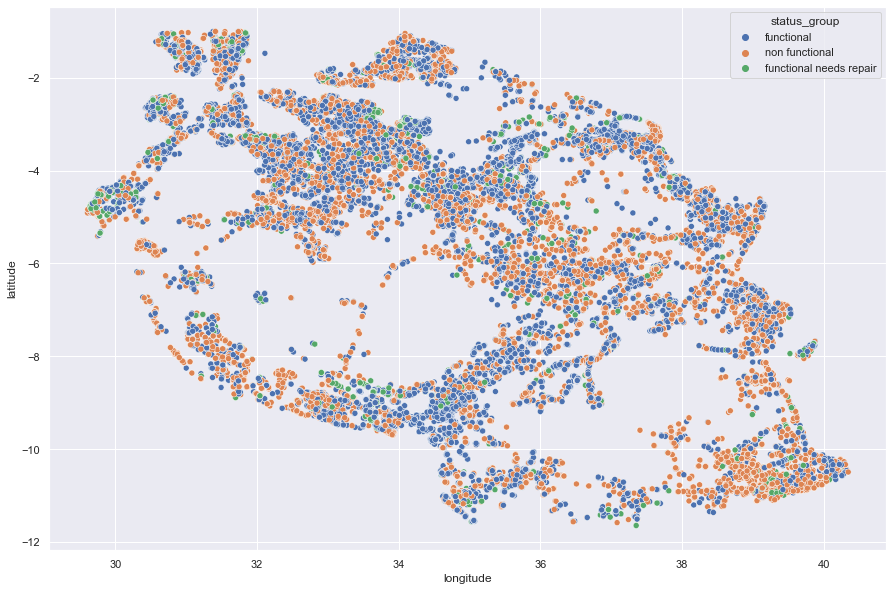

In [16]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.scatterplot(x = 'longitude', y = 'latitude', data = train,  hue = 'status_group')

In [17]:

report = ProfileReport(train, minimal=True).to_notebook_iframe()

report

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# II. Split Data

## Split Target Vector from Feature Matrix

In [18]:
target = 'status_group'

y = train[target]

X = train.drop(columns = target)

## Training-Validation Split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 5)

# III. Establish Baseline

- Is this a *regression* or a *classification* problem?
- Because it's a **classification** problem, we need to calculate baseline accuracy based on our majority class. 

In [20]:
print('Baseline Accurary', y_train.value_counts(normalize = True).max()*100)

Baseline Accurary 54.1266835016835


# IV. Build Model(s)

- Encoder for categorical features.
- Imputer for missing values.
- `StandardScaler` for `LogisticRegression`

**First Model:** Logistic Regression

# Standard Scaler
A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. 

Z-score is measured in terms of standard deviations from the mean. 

OFF - Comment out if we want to interpret the coefficients. Will take longer and maybe reach max interation before convergence.

ON - But if im ok with the coefficients not being as interpretable or if interpreting them in terms of the number of std deviations from the mean of the column then I can leave it on.  That will have an advantage of making the algorithm run faster. If you dont scale your data you may not 'converge' within the given iterations. ??
    - Make quicker
    - Log regression no but some models require scaling ahead of time. Neural network models require scaling before passing into the network. 



In [26]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True), #use_cat_names will create feature names according to the unique values of categorical variables
    SimpleImputer(strategy='mean'), #will take the missing vaules and impute them with some value. Mean in this strategy.
    StandardScaler(), #will put everything on a scale according to the z score. 

    LogisticRegression(max_iter=200) #  Too low will fail. Too high will be long time I guess. 
)

model_lr.fit(X_train, y_train)

c:\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

**Second Model:** Decision Tree Classifier

In [28]:
model_dt = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state= 42, max_depth=16)  # This changes to use DT.  It requires a random state. Any number.
)
# 16 depth it to prevent overfitting. 
model_dt.fit(X_train, y_train)

c:\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=16, random_sta

**Interlude: How does a tree model work?**

[Text(1674.0, 733.86, 'X[139] <= 1.294\ngini = 0.553\nsamples = 47520\nvalue = [25721, 3479, 18320]'),
 Text(837.0, 570.78, 'X[166] <= 1.266\ngini = 0.531\nsamples = 42559\nvalue = [25604, 3449, 13506]'),
 Text(418.5, 407.70000000000005, 'X[165] <= 1.315\ngini = 0.502\nsamples = 38543\nvalue = [24938, 3227, 10378]'),
 Text(209.25, 244.62, 'X[119] <= 0.149\ngini = 0.478\nsamples = 34376\nvalue = [23206, 2717, 8453]'),
 Text(104.625, 81.54000000000008, '\n  (...)  \n'),
 Text(313.875, 81.54000000000008, '\n  (...)  \n'),
 Text(627.75, 244.62, 'X[55] <= -0.53\ngini = 0.599\nsamples = 4167\nvalue = [1732, 510, 1925]'),
 Text(523.125, 81.54000000000008, '\n  (...)  \n'),
 Text(732.375, 81.54000000000008, '\n  (...)  \n'),
 Text(1255.5, 407.70000000000005, 'X[76] <= 1.263\ngini = 0.363\nsamples = 4016\nvalue = [666, 222, 3128]'),
 Text(1046.25, 244.62, 'X[12] <= 0.868\ngini = 0.55\nsamples = 1143\nvalue = [333, 132, 678]'),
 Text(941.625, 81.54000000000008, '\n  (...)  \n'),
 Text(1150.875, 

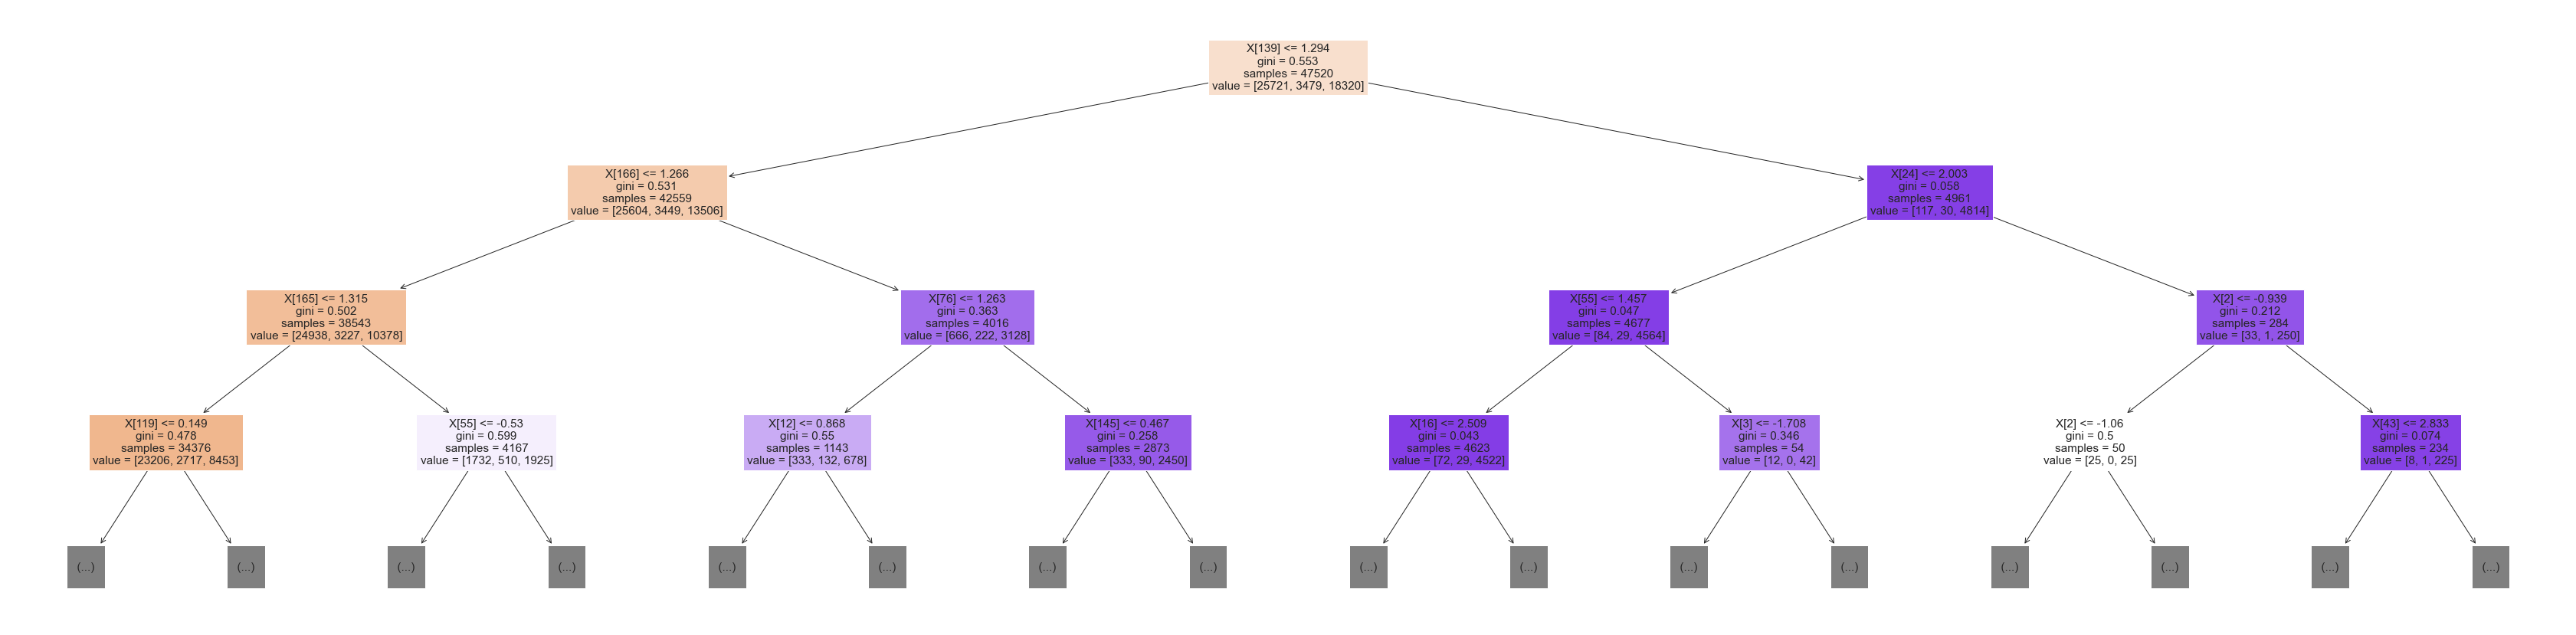

In [32]:
plt.figure(figsize = (60,15))

plot_tree(model_dt.named_steps['decisiontreeclassifier'], 
          max_depth = 3,
          #feature_names = X_train.columns,
          filled = True)
# GraphViz is the worst. Crashes.

In [36]:
model_dt_or = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state= 42, max_depth=4)
)

model_dt_or.fit(X_train, y_train)

c:\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, random_stat

# V. Check Metrics

In [33]:
print('model_lr accuracy score for training', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val', accuracy_score(y_val, model_lr.predict(X_val)))

model_lr accuracy score for training 0.7376052188552189
model_lr accuracy score for val 0.7404882154882155


In [34]:
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt.predict(X_val)))

model_dt accuracy score for training 0.8460016835016835
model_dt accuracy score for val 0.7686026936026936


In [37]:
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt_or.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt_or.predict(X_val)))

model_dt accuracy score for training 0.7061658249158249
model_dt accuracy score for val 0.7117003367003367


# VI. Tune Model

Let's look at the hyperparameter `max_depth`

In [70]:
depths = range(14, 20, 1)  # These reflect different max depth values

list(depths)

[14, 15, 16, 17, 18, 19]

In [71]:
train_acc = []
val_acc = []

for depth in depths:
   
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

In [72]:
val_acc

[0.7640572390572391,
 0.7631313131313131,
 0.7658249158249159,
 0.7693602693602694,
 0.7675084175084175,
 0.7634680134680135]

In [73]:
train_acc

[0.8418350168350168,
 0.8590488215488216,
 0.8781986531986532,
 0.8949284511784512,
 0.9111531986531987,
 0.9265782828282828]

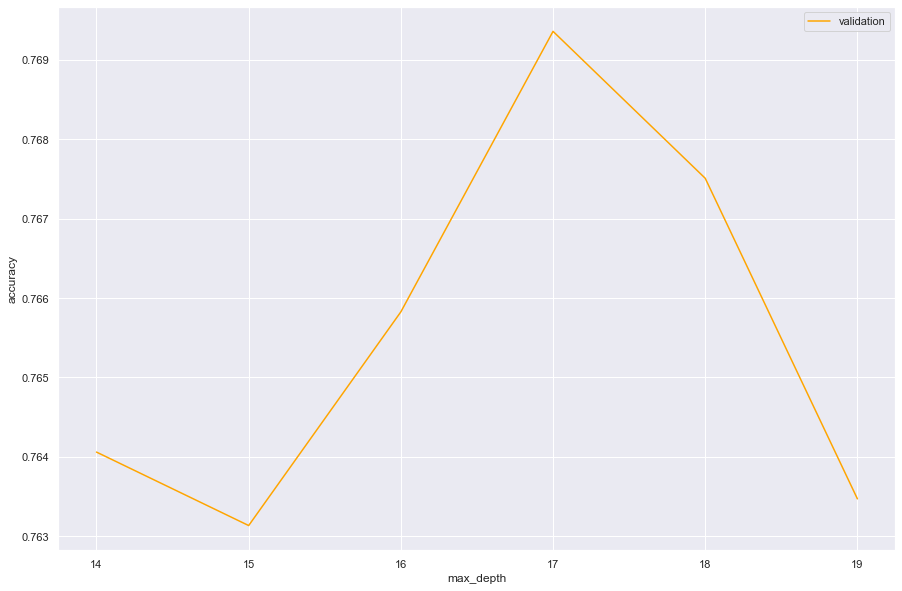

In [74]:
#plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# VII. Communicate Results


### Gini importance

Text(0.5, 0, 'gini importance')

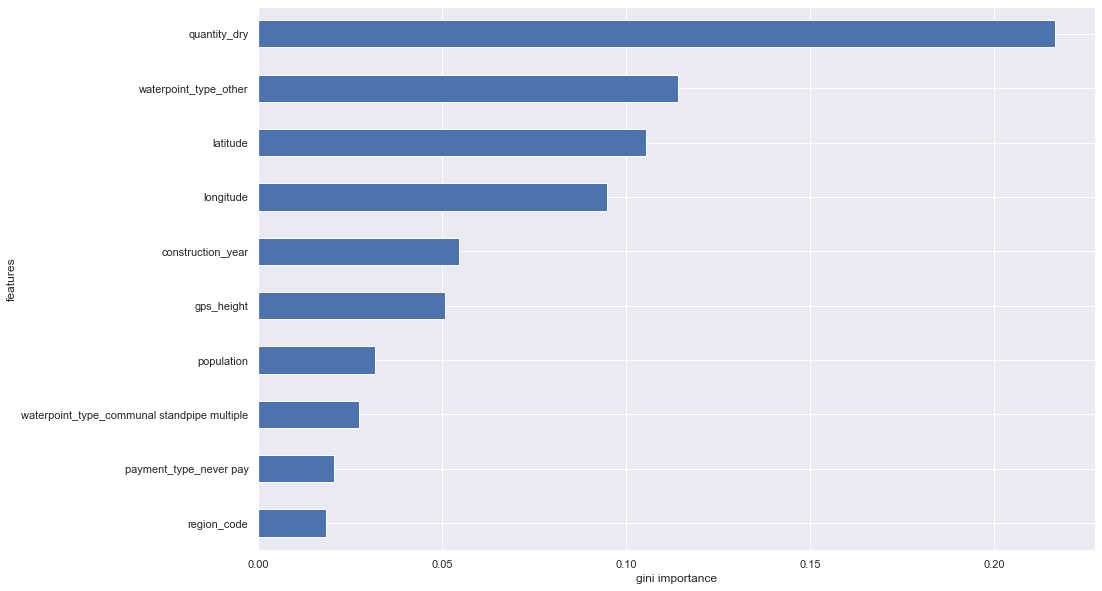

In [75]:
features = model_dt.named_steps['onehotencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')

#Text(0.5, 111.5, 'gini importance')

In [78]:
sample_submission = pd.read_csv(r'waterpumps/sample_submission.csv')
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [79]:
# generate CSV
sample_submission.to_csv('sample_submission_Vignesh.csv', index=False)

In [84]:
# download the file
# from google.colab import files
# files.download("sample_submission_Vignesh.csv")

In [85]:
X_test = pd.read_csv(r'waterpumps/test_features.csv')

In [86]:
X_test = wrangle(X_test)

X_test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [91]:
(X_test.columns)

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [92]:
(X_train.columns)

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [93]:
set(X_test.columns) - set(X_train.columns)

{'date_recorded',
 'funder',
 'installer',
 'lga',
 'num_private',
 'quantity_group',
 'recorded_by',
 'scheme_name',
 'subvillage',
 'ward',
 'wpt_name'}

In [94]:
def Diff(li1, li2):
#     return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
     return list(set(li1) - set(li2))


cols_to_drop = Diff(X_test.columns, X_train.columns)

cols_to_drop

['date_recorded',
 'scheme_name',
 'quantity_group',
 'recorded_by',
 'funder',
 'subvillage',
 'wpt_name',
 'lga',
 'ward',
 'installer',
 'num_private']

In [95]:
X_test = X_test.drop(columns=cols_to_drop)

In [96]:
predictions = pd.DataFrame(data=model_lr.predict(X_test), index=X_test.index)

predictions.columns = ['status_group']

predictions.insert(0, 'id', predictions.index)

predictions = predictions.reset_index(drop=True)


In [100]:
# generate CSV
predictions.to_csv(r'waterpumps/sample_submission_Vignesh_class.csv', index=False)

# download
# from google.colab import files
# files.download("sample_submission_Vignesh_class.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
